In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hyperopt
from hyperopt import fmin, hp, Trials
import torch.cuda
from sklearn.metrics import classification_report

def get_data(random_state=None):
    # Read the data, specifying the decimal separator
    df = pd.read_excel("final_data492.xlsx", decimal=',')

    # Drop unnecessary columns and separate features and target variable
    df_dropped = df.drop(columns=['interview_score', 'result_2'])

    df_dropped['n_of_applicants'] = df_dropped.groupby(['year', 'is_fall'])['year'].transform('count')
    df_dropped.drop(columns=['year'], inplace=True)

    X = df_dropped.drop(columns=['result_1'])
    y = df_dropped['result_1'].values

    # Split the data into train and test sets with random_state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


def visualize_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

In [ ]:
# 1 hidden layer NN
class NN1(nn.Module):
    def __init__(self, dropout):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 3)  # Output layer directly from 128 to 3
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2 hidden layer NN
class NN2(nn.Module):
    def __init__(self, dropout):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)  # Output layer directly from 64 to 3
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 3 hidden layer NN
class NN3(nn.Module):
    def __init__(self, dropout):
        super(NN3, self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)  # Output layer directly from 32 to 3
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# 4 hidden layer NN
class NN4(nn.Module):
    def __init__(self, dropout):
        super(NN4, self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 3)   # Output layer directly from 16 to 3
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# 5 hidden layer NN
class NN5(nn.Module):
    def __init__(self, dropout):
        super(NN5, self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 3)    # Output layer directly from 8 to 3
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameter search spaces
hyperparameter_space = {
    "n_layers": hp.choice("n_layers", [1, 2, 3, 4, 5]),
    "n_epochs": hp.quniform("n_epochs", 5, 100, 1),
    "optimizer": hp.choice("optimizer", ["Adam"]),
    "dropout": hp.uniform("dropout", 0.0, 0.7),
    "learning_rate": hp.loguniform("learning_rate", -12, 0),
    "batch_size": hp.choice("batch_size", [1, 2, 4, 8, 16, 32, 64]),
}


# helper function that returns optimizer
def _get_optimizer(algorithm, learning_rate, model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #if algorithm == "Adam":
    #    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #elif algorithm == "SGD":
    #    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #else:
    #    optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
    return optimizer

def _get_model(n_layers, dropout):
    model = None
    if n_layers == 1:
        model = NN1(dropout)
    elif n_layers == 2:
        model = NN2(dropout)
    elif n_layers == 3:
        model = NN3(dropout)
    elif n_layers == 4:
        model = NN4(dropout)
    else:
        model = NN5(dropout)
    return model.to(device)  # Move model to CUDA if available

X_train, X_test, y_train, y_test = get_data()

# Convert data into tensors and move to CUDA
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)
# Calculate class weights
#class_counts = np.bincount(y_train)
#total_samples = len(y_train)
#class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float)
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
# Convert data into batches using DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)

In [ ]:
def train_model(n_layers, n_epochs, dropout, learning_rate, optimizer_name, batch_size):
    model = _get_model(n_layers, dropout)

    optimizer = _get_optimizer(optimizer_name, learning_rate, model)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on test data
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Loss = {test_loss.item()} Test Accuracy = {test_accuracy}")
    return test_loss.item()

# objective function
def objective(params):
    print(params)
    n_layers = params["n_layers"]
    n_epochs = int(params["n_epochs"])
    optimizer = params["optimizer"]
    dropout = params["dropout"]
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    loss = train_model(n_layers, n_epochs, dropout, learning_rate, optimizer, batch_size)
    return loss

# tpe search
trials = Trials()
best_tpe = fmin(fn=objective, space=hyperparameter_space, algo=hyperopt.tpe.suggest, trials=trials, max_evals=400)

{'batch_size': 64, 'dropout': 0.5851240197052956, 'learning_rate': 0.009323818455397703, 'n_epochs': 23.0, 'n_layers': 1, 'optimizer': 'Adam'}
Test Loss = 0.1882203370332718 Test Accuracy = 0.9252336448598131
{'batch_size': 8, 'dropout': 0.5541303872054386, 'learning_rate': 0.25654759297534413, 'n_epochs': 99.0, 'n_layers': 4, 'optimizer': 'Adam'}
Test Loss = 0.954780101776123 Test Accuracy = 0.5607476635514018
{'batch_size': 16, 'dropout': 0.39813500905953864, 'learning_rate': 0.0071823595277521616, 'n_epochs': 46.0, 'n_layers': 3, 'optimizer': 'Adam'}
Test Loss = 0.19390562176704407 Test Accuracy = 0.9158878504672897
{'batch_size': 2, 'dropout': 0.20132410149419266, 'learning_rate': 6.840164047569174e-05, 'n_epochs': 90.0, 'n_layers': 5, 'optimizer': 'Adam'}
Test Loss = 0.1992020159959793 Test Accuracy = 0.9439252336448598
{'batch_size': 2, 'dropout': 0.3669507850757562, 'learning_rate': 0.00012191268107209536, 'n_epochs': 79.0, 'n_layers': 1, 'optimizer': 'Adam'}
Test Loss = 0.22860

KeyboardInterrupt: 

In [ ]:
for i in range(5):
    X_train, X_test, y_train, y_test = get_data(random_state=i)

    # Convert data into tensors and move to CUDA
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)
    # Calculate class weights
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)
    # Convert data into batches using DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)

    def train_model2(n_layers, n_epochs, dropout, learning_rate, optimizer_name, batch_size):
        model = _get_model(n_layers, dropout)

        optimizer = _get_optimizer(optimizer_name, learning_rate, model)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        for epoch in range(n_epochs):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model on test data
        with torch.no_grad():
            model.eval()
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, predicted = torch.max(test_outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print(f"Test Loss = {test_loss.item()} Test Accuracy = {test_accuracy}")

    train_model2(2, 42, 0.603, 0.0017172, "Adam", 16)

Test Loss = 0.3242376148700714 Test Accuracy = 0.8878504672897196
Test Loss = 0.18774451315402985 Test Accuracy = 0.897196261682243
Test Loss = 0.3843514323234558 Test Accuracy = 0.9252336448598131
Test Loss = 0.21327005326747894 Test Accuracy = 0.9065420560747663
Test Loss = 0.24204270541667938 Test Accuracy = 0.8785046728971962


Test Loss = 0.40804529190063477 Test Accuracy = 0.9065420560747663


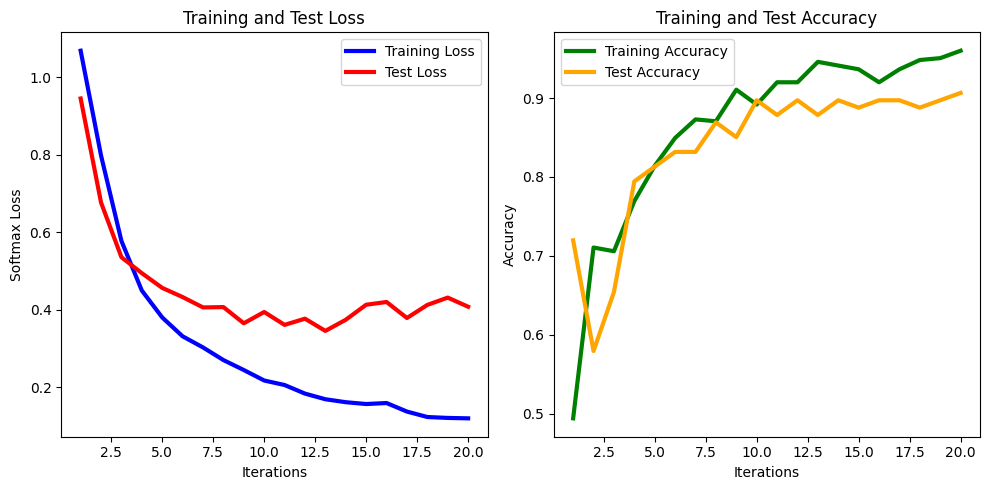

In [ ]:
# Read the data, specifying the decimal separator
df = pd.read_excel("final_data492.xlsx", decimal=',')
# Drop unnecessary columns and separate features and target variable
#df_dropped = df.drop(columns=['interview_score', 'result_2'])
df_dropped = df.drop(columns=['interview_score'])

df_dropped['n_of_applicants'] = df_dropped.groupby(['year', 'is_fall'])['year'].transform('count')
df_dropped.drop(columns=['year'], inplace=True)

X = df_dropped.drop(columns=['result_1'])
y = df_dropped['result_1'].values

# Split the data into train and test sets with random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Standardize the data
scaler = StandardScaler()
y_result2 = X_test["result_2"]
X_train.drop(columns=['result_2'], inplace=True)
X_test.drop(columns=['result_2'], inplace=True)
X_train = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Convert data into tensors and move to CUDA
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)
# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)
# Convert data into batches using DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)

n_layers = 2
n_epochs = 20
dropout = 0.603
learning_rate = 0.0017172
optimizer_name = "Adam"
batch_size = 24

model = _get_model(n_layers, dropout)

optimizer = _get_optimizer(optimizer_name, learning_rate, model)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)  # Multiply by batch size to get total loss
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    epoch_train_loss /= len(train_loader.dataset)  # Divide by total number of samples
    train_losses.append(epoch_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())
        _, predicted_test = torch.max(test_outputs, 1)
        total_test = y_test_tensor.size(0)
        correct_test = (predicted_test == y_test_tensor).sum().item()
        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)

with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    # Apply softmax to get probabilities
    test_probs = torch.softmax(test_outputs, dim=1)
print(f"Test Loss = {test_loss.item()} Test Accuracy = {test_accuracy}")

# Plotting
plt.figure(figsize=(10, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=3)
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss', color='red', linewidth=3)
plt.xlabel('Iterations')
plt.ylabel('Softmax Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy', color='green', linewidth=3)
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy', color='orange', linewidth=3)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
predicted

tensor([2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 1, 1,
        2, 1, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
        0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 1, 2, 0, 0, 2, 0, 1, 0,
        0, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2,
        2, 0, 1, 1, 0, 0, 2, 1, 2, 0, 0])

In [ ]:
y_test

array([2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0,
       1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 2,
       0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 1, 2, 2, 0])

In [ ]:
test_probs_np = test_probs.cpu().numpy()
# Create new columns for each class probability in X_test
for i in range(test_probs_np.shape[1]):
    X_test[f"prob_class_{i}"] = test_probs_np[:, i]

In [ ]:
X_test["actual"] = y_test
X_test["pred"] = np.array(predicted.cpu())
X_test["result2"] = y_result2.values

In [ ]:
X_test

,is_fall,is_boun,is_ie,gpa,ales,uni_score,n_of_applicants,prob_class_0,prob_class_1,prob_class_2,actual,pred,result2
110,1,0,0,3.08,86.622400,480.525930,67,4.536733e-02,1.248570e-02,0.942147,2,2,1.0
244,0,0,1,3.54,89.000000,483.320000,86,9.351608e-01,2.064154e-06,0.064837,0,0,1.0
430,1,0,1,3.51,98.350000,486.926600,42,9.931961e-01,1.403414e-09,0.006804,0,0,NaN
438,1,0,1,3.19,94.809998,486.926600,42,8.094774e-01,1.330998e-05,0.190509,0,0,NaN
233,0,0,1,3.21,96.260002,483.320000,86,9.722345e-01,3.682799e-07,0.027765,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0,0,3.69,83.269997,280.781639,96,1.525556e-03,2.449005e-03,0.996025,2,2,1.0
519,1,0,0,2.59,80.000000,307.701344,37,1.712411e-11,9.678197e-01,0.032180,1,1,NaN
370,1,0,1,3.07,84.410004,485.110000,96,9.217194e-02,1.308568e-03,0.906520,2,2,1.0
255,0,0,1,3.21,91.830002,421.070000,86,6.670275e-01,2.245471e-04,0.332748,2,0,1.0


In [ ]:
X_test.to_excel("NN_predictions.xlsx")

In [ ]:
torch.save(model.state_dict(), "NN_model.pt")

In [ ]:
y_pred = np.array(predicted.cpu())
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.918919,1.000000,0.957746,34.000000
1,0.809524,0.850000,0.829268,20.000000
2,0.938776,0.867925,0.901961,53.000000
accuracy,0.906542,0.906542,0.906542,0.906542
macro avg,0.889073,0.905975,0.896325,107.000000
weighted avg,0.908307,0.906542,0.906100,107.000000
